# PART 3: Hospital Beds per Hundred per Neighborhood

In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## This notebook will utilize the Foursquare API to explore the hospitals in New York neighborhoods.

### We have New York neighborhoods dataset and hospital&beds dataset ready for use.

In [2]:
ny_data = pd.read_csv('data_output/new_york_data.csv')
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude,Population
0,Bronx,Wakefield,40.894705,-73.847201,29158.0
1,Bronx,Co-op City,40.874294,-73.829939,43752.0
2,Bronx,Fieldston,40.895437,-73.905643,3292.0
3,Bronx,Riverdale,40.890834,-73.912585,48049.0
4,Bronx,Kingsbridge,40.881687,-73.902818,10669.0


In [24]:
# Let us see some bar charts of this data
def show_bar_chart(data, group, field, title, x_label, y_label, calculation="sum"):
    """
    A function to render bar charts
    """
    plt.figure(figsize=(9, 5))
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    if calculation == "sum":
        data.groupby(group)[field].sum().plot(kind='bar')
    if calculation == "count":
        data.groupby(group)[field].count().plot(kind='bar')
    if calculation == 'average':
        data.groupby(group)[field].mean().plot(kind='bar')
    plt.legend()
    plt.savefig('image_output/{}.png'.format(title))

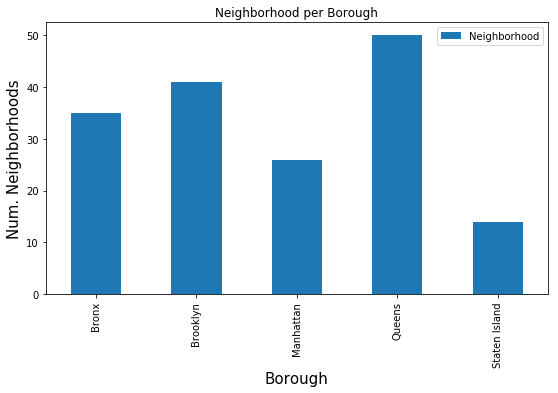

In [25]:
show_bar_chart(data = ny_data, group="Borough", field="Neighborhood", title="Neighborhood per Borough",  x_label="Borough",
               y_label="Num. Neighborhoods", calculation = 'count')

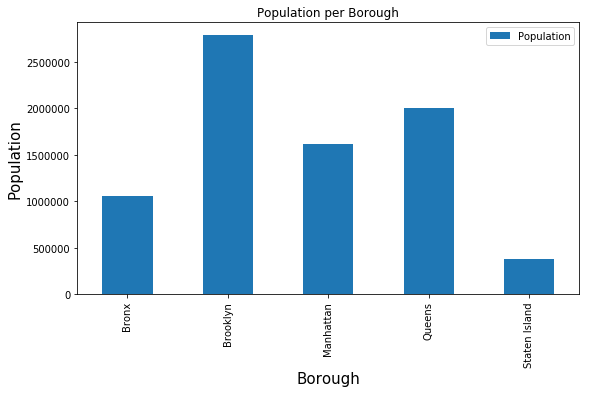

In [26]:
show_bar_chart(data = ny_data, group="Borough", field="Population", title="Population per Borough",  x_label="Borough", y_label="Population")

In [11]:
ny_hospital = pd.read_csv('data_output/hospital_beds.csv')
ny_hospital.head()

,Hospital,Intensive Care Beds,Medical / Surgical Beds,Total Beds
0,Jamaica Hospital Medical Center,8,228,402
1,"New York Community Hospital of Brooklyn, Inc",7,127,134
2,Mount Sinai Hospital,85,639,1134
3,Nassau University Medical Center,22,158,530
4,Richmond University Medical Center,20,286,448


## Get hospital data for each neighborhood based on latitude and longitude

In [12]:
# Now, let us fetch hospital information for each Neighborhood
def get_hospital_data(lat, lng, borough, neighborhood):
    """
    We are going to utilize foursquare API to fetch hospital data. It will take latitude,     
    longitude and return hospital information.
    """
    radius = 1000
    LIMIT = 100
    VERSION = '20200423'
    FS_CLIENT_ID = "XMZPVPZ1FGMNNEJEIIMJGEZNGXHYFEAPG1Z4LSZJQJOIWUAR"
    FS_CLIENT_SECRET = "AF1GJRPBSLJSBH1KD5UGIAA3HCDJH5SBYPWDPD1PTGBVE0BW"
    FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_HOSPITAL_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [13]:
# Let us also write another function to utilize the nyc_df to get hospital data
def get_hospital_per_neighborhood_borough(df):
    """
    It will utilize ny_data and get hospital per neighborhood.
    """
    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        h_df = get_hospital_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
    n_df.to_csv('data_output/hospital_per_boro_nei.csv')
    return n_df

In [14]:
# Now let us use the above function
hospital_df = get_hospital_per_neighborhood_borough(ny_data)
hospital_df.head()

,ID,Name,Latitude,Longitude,Borough,Neighborhood
0,59832a7bfe37406ea7eb3a79,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Bronx,Co-op City
1,50173409e4b0cfe38c43abf4,wellcare,40.874247,-73.837745,Bronx,Co-op City
2,568e86f5498ec6df53771448,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Bronx,Co-op City
3,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Fieldston
4,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Riverdale


In [15]:
# Now let us combine hospital ber neighborhood data with hospital bed data
def combine_hospital_beds_with_boro_neighborhood(hospital_df, hospital_boro_nei_df):
    # Uses fuzzywuzzy to match hospital name from Foursquare to NYS
    data = []
    column_names = ["Hospital", "Intensive Care Beds", "Medical / Surgical Beds","Total Beds"]
    boro_neig_column_names = ["Borough", "Neighborhood"]
    for i, row in hospital_df.iterrows():
        data_per_hospital = None
        max_ratio = 0
        for x, hrow in hospital_boro_nei_df.iterrows():
            ratio = fuzz.token_sort_ratio(row["Hospital"], hrow["Name"])
            if ratio > max_ratio:
                max_ratio = ratio
                data_per_hospital = [
                    row[column] for column in column_names] + \
                    [hrow[column] for column in boro_neig_column_names
                     ]
        if data_per_hospital:
            data.append(data_per_hospital)

    df = pd.DataFrame(data, columns=column_names+boro_neig_column_names)
    df.to_csv('data_output/cleaned_hospital_data.csv',index = False)
    return df

In [16]:
h_df = combine_hospital_beds_with_boro_neighborhood(ny_hospital,hospital_df)

In [17]:
h_df.sort_values(by='Total Beds', ascending = False).head(20)

,Hospital,Intensive Care Beds,Medical / Surgical Beds,Total Beds,Borough,Neighborhood
2,Mount Sinai Hospital,85,639,1134,Manhattan,East Harlem
71,New York-Presbyterian Hospital - Columbia Pres...,99,551,1022,Manhattan,Inwood
35,Bellevue Hospital Center,40,290,912,Manhattan,Murray Hill
16,New York-Presbyterian Hospital - New York Weil...,85,427,862,Manhattan,Turtle Bay
36,NYU Langone Hospitals,161,409,844,Manhattan,Murray Hill
10,Montefiore Medical Center - Henry & Lucy Moses...,48,581,816,Bronx,Norwood
17,North Shore University Hospital,97,486,756,Staten Island,Stapleton
31,Maimonides Medical Center,40,448,711,Brooklyn,Borough Park
26,Mount Sinai Beth Israel,36,499,696,Manhattan,East Village
19,Lenox Hill Hospital,15,476,632,Manhattan,Upper East Side


In [38]:
# Let us clean up the data by combining total bed count and icu bed count per neighborhood and borough
h_df = h_df.groupby(["Borough","Neighborhood", ]).agg(
    {
        "Intensive Care Beds": "sum",
        "Medical / Surgical Beds": "sum",
        "Total Beds": "sum"
    }
)
h_df

Intensive Care Beds  \
Borough       Neighborhood                                     
Bronx         East Tremont                                14   
              Fordham                                     70   
              Melrose                                     59   
              Morris Heights                              28   
              Morrisania                                  26   
              Norwood                                     80   
              Pelham Bay                                   0   
              Pelham Parkway                              22   
              Woodlawn                                    16   
Brooklyn      Bensonhurst                                  8   
              Borough Park                                40   
              Brighton Beach                              17   
              Brownsville                                 26   
              Bushwick                                    16   
              Carroll Gardens                             29   
              Crown Heights                               13   
              Erasmus                                     36   
              Fort Greene                                 31   
              Gravesend                                   22   
              Prospect Heights                             8   
              Prospect Lefferts Gardens                   27   
              Sunset Park                                 24   
              Williamsburg                                 0   
              Windsor Terrace                             40   
Manhattan     Chinatown                                   13   
              Clinton                                     12   
              East Harlem                                191   
              East Village                                49   
              Inwood                                     105   
              Marble Hill                                 12   
              Murray Hill                                221   
              Turtle Bay                                 107   
              Upper East Side                             15   
              Upper West Side                             71   
              Yorkville                                    4   
Queens        Briarwood                                   24   
              Far Rockaway                                 8   
              Forest Hills                                28   
              Glen Oaks                                    8   
              Jackson Heights                             20   
              Ridgewood                                   12   
              South Ozone Park                            11   
Staten Island South Beach                                 46   
              Stapleton                                  162   
              West Brighton                               20   

                                         Medical / Surgical Beds  Total Beds  
Borough       Neighborhood                                                    
Bronx         East Tremont                                   151         282  
              Fordham                                        593        1029  
              Melrose                                        520        1118  
              Morris Heights                                 271         444  
              Morrisania                                     250         585  
              Norwood                                        776        1169  
              Pelham Bay                                     225         225  
              Pelham Parkway                                 304         421  
              Woodlawn                                       206         321  
Brooklyn      Bensonhurst                                    183         204  
              Borough Park                                   448         711  
     

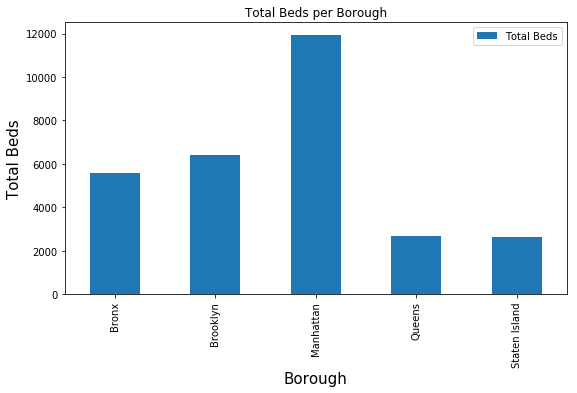

In [27]:
show_bar_chart(data = h_df, group="Borough", field="Total Beds", title="Total Beds per Borough",  
               x_label="Borough", y_label="Total Beds")

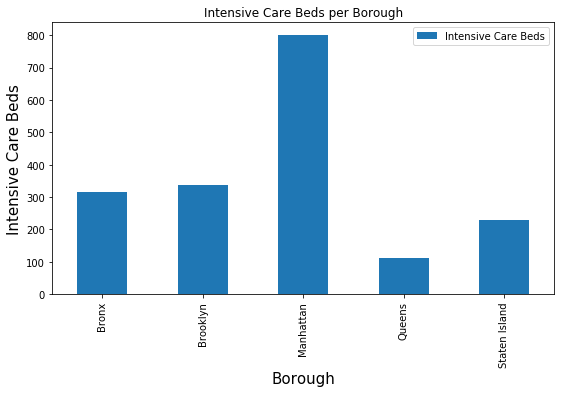

In [28]:
show_bar_chart(data = h_df, group="Borough", field="Intensive Care Beds", title="Intensive Care Beds per Borough",  
               x_label="Borough", y_label="Intensive Care Beds")

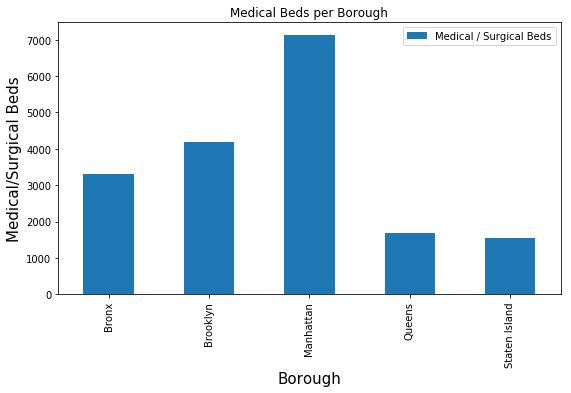

In [30]:
show_bar_chart(data = h_df, group="Borough", field="Medical / Surgical Beds", title="Medical Beds per Borough",  
               x_label="Borough", y_label="Medical/Surgical Beds")

### Combine data

In [46]:
df = ny_data.merge(h_df, on=['Borough','Neighborhood'], how = 'inner')
df

,Borough,Neighborhood,Latitude,Longitude,Population,Intensive Care Beds,Medical / Surgical Beds,Total Beds
0,Manhattan,Marble Hill,40.876551,-73.910660,9481.0,12,71,103
1,Bronx,Woodlawn,40.898273,-73.867315,42483.0,16,206,321
2,Bronx,Norwood,40.877224,-73.879391,40494.0,80,776,1169
3,Bronx,Pelham Parkway,40.857413,-73.854756,30073.0,22,304,421
4,Bronx,Morris Heights,40.847898,-73.919672,36779.0,28,271,444
5,Bronx,Fordham,40.860997,-73.896427,43394.0,70,593,1029
6,Bronx,East Tremont,40.842696,-73.887356,43423.0,14,151,282
7,Bronx,Melrose,40.819754,-73.909422,24913.0,59,520,1118
8,Bronx,Morrisania,40.823592,-73.901506,16863.0,26,250,585
9,Bronx,Pelham Bay,40.850641,-73.832074,11931.0,0,225,225


In [47]:
#We will add bed per 100 people data with the dataframe
def get_bed_per_hunderd_person(row, field="Total Beds"):
    """
    Will return bed per hundered data. field can be beds or icu beds
    """
    return row[field] * 100 / row["Population"]

df["Intensive Care Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row, field="Intensive Care Beds"), axis=1)

df["Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row), axis=1)

df.head()

,Borough,Neighborhood,Latitude,Longitude,Population,Intensive Care Beds,Medical / Surgical Beds,Total Beds,Intensive Care Bed Per Hundred People,Bed Per Hundred People
0,Manhattan,Marble Hill,40.876551,-73.910660,9481.0,12,71,103,0.126569,1.086383
1,Bronx,Woodlawn,40.898273,-73.867315,42483.0,16,206,321,0.037662,0.755596
2,Bronx,Norwood,40.877224,-73.879391,40494.0,80,776,1169,0.197560,2.886847
3,Bronx,Pelham Parkway,40.857413,-73.854756,30073.0,22,304,421,0.073155,1.399927
4,Bronx,Morris Heights,40.847898,-73.919672,36779.0,28,271,444,0.076130,1.207211


In [48]:
df.to_csv('data_output/final_df_for_clustering.csv', index = False)